Auto Encoder


*   Leaky Relu
*   27 --> 18 --> |16| --> 18 --> 27
*   Raw Score: 40.60740740740741
*   Grade: Moderate
*   Score: 42
*   Patient ID: SB-001



In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Load Data
df_am = pd.read_csv('SB-001_normalized_AM.csv')
df_pm = pd.read_csv('SB-001_normalized_PM.csv')
FILE_NAME  = "Auto Encoder-L27_18_16-S42-ALRelu-E100-Psb001"
PATIENT_ID = "SB-001"
combined_df = pd.concat([df_am, df_pm])

columns_needed = ['income', 'road_dist', 'cooking', 'y_am_pef', 'tempin', 'humidin', 'pm25in', 'co2in', 'tempdiffin', 'humidiffin', 'pm25diffin', 'pm10', 'pm25', 'o3', 'no2', 'co', 'so2', 'temp', 'windsd', 'humid', 'varp', 'dewpt', 'airp', 'seap', 'solrhr', 'solramnt', 'grdt', 'class']
combined_df = combined_df.filter(columns_needed)
df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt,class
0,0.0,0.5,0.5,NaN,0.247,0.170,0.324,0.158,0.749,0.410,...,0.384,0.280,0.061,0.231,0.602,0.611,0.781,0.299,0.194,1.0
1,0.0,0.5,0.5,NaN,0.577,0.630,0.318,0.512,0.103,0.627,...,0.038,0.442,0.497,0.760,0.528,0.517,0.898,0.844,0.844,1.0
2,0.0,0.5,0.5,NaN,0.282,0.314,0.389,0.419,0.555,0.105,...,0.275,0.687,0.209,0.505,0.902,0.895,0.448,0.132,0.240,1.0
3,0.0,0.5,0.5,0.421,0.431,0.283,0.231,0.083,0.421,0.588,...,0.799,0.197,0.181,0.461,0.372,0.373,0.927,0.807,0.452,1.0
4,0.0,0.5,0.5,0.350,0.597,0.647,0.599,0.439,0.338,0.276,...,0.034,0.798,0.479,0.746,0.564,0.557,0.614,0.648,0.645,1.0


In [3]:
# Drop NaN
df = df.dropna()
print(len(df))

# Minotity Split
class_counts = df['class'].value_counts()
minority_class = df[df['class'] == 0]
majority_class = df[df['class'] == 1]

188


In [4]:
# Removing class column from minority before augmentation
X = minority_class.drop('class', axis=1)
y = minority_class['class']

# Saving minority as X_train
X_train = X
print(X_train.shape)

(57, 27)


In [5]:
X_train.head()

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,temp,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt
6,0.0,0.5,0.5,0.268,0.851,0.660,0.154,0.628,0.247,0.455,...,0.822,0.484,0.643,0.581,0.804,0.486,0.475,0.246,0.399,0.694
7,0.0,0.5,0.5,0.415,0.425,0.253,0.342,0.344,0.585,0.346,...,0.430,0.038,0.394,0.164,0.427,0.842,0.836,0.156,0.120,0.272
17,0.0,0.5,0.5,0.310,0.556,0.429,0.796,0.357,0.576,0.310,...,0.466,0.107,0.580,0.218,0.512,0.662,0.658,0.394,0.223,0.291
23,0.0,0.5,0.5,0.284,0.813,0.749,0.291,0.384,0.154,0.396,...,0.898,0.226,0.774,0.772,0.906,0.536,0.518,0.311,0.202,0.836
25,0.0,0.5,0.5,0.228,0.143,0.000,0.108,0.146,0.992,0.445,...,0.007,0.806,0.086,0.000,0.000,0.896,0.906,0.787,0.286,0.021


In [6]:
# Check no NaN exists
nan_count = X_train.isna().sum()
columns_with_nan = nan_count[nan_count > 0]

print("Columns with NaN values:")
print(columns_with_nan)

Columns with NaN values:
Series([], dtype: int64)


In [7]:
# Define the Input shape
INPUT_SHAPE = X_train.shape[1]
INPUT_SHAPE

27

In [8]:
# Auto Encoder Model
encoder_input = keras.Input(shape=(INPUT_SHAPE,), name="input")
x = keras.layers.Flatten()(encoder_input)
dense1 = keras.layers.Dense(18, activation=tf.nn.leaky_relu)(x)
batch_norm1 = keras.layers.BatchNormalization()(dense1)
encoder_output = keras.layers.Dense(16, activation=tf.nn.leaky_relu)(batch_norm1)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")

decoder_input = keras.layers.Dense(18, activation=tf.nn.leaky_relu)(encoder_output)
batch_norm2 = keras.layers.BatchNormalization()(decoder_input)
dense2 = keras.layers.Dense(INPUT_SHAPE, activation=tf.nn.leaky_relu)(batch_norm2)

batch_norm3 = keras.layers.BatchNormalization()(dense2)
decoder_output = tf.reshape(batch_norm3, (-1, 1, INPUT_SHAPE))

opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
decoder = keras.Model(decoder_input, decoder_output)

autoencoder.summary()
#27 --> 18 --> |16| --> 18 --> 27

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 27)]              0         
                                                                 
 flatten (Flatten)           (None, 27)                0         
                                                                 
 dense (Dense)               (None, 18)                504       
                                                                 
 batch_normalization (BatchN  (None, 18)               72        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 16)                304       
                                                                 
 dense_2 (Dense)             (None, 18)                306       
                                                       

In [9]:
autoencoder.compile(opt, loss = "mse")

In [11]:
history = autoencoder.fit(X_train, X_train, epochs=200, batch_size = 16, validation_split = 0.1)

Epoch 1/200
4/4 [==============================] - 0s 57ms/step - loss: 0.4029 - val_loss: 0.2198
Epoch 2/200
4/4 [==============================] - 0s 31ms/step - loss: 0.3974 - val_loss: 0.2170
Epoch 3/200
4/4 [==============================] - 0s 32ms/step - loss: 0.3967 - val_loss: 0.2142
Epoch 4/200
4/4 [==============================] - 0s 28ms/step - loss: 0.3908 - val_loss: 0.2090
Epoch 5/200
4/4 [==============================] - 0s 38ms/step - loss: 0.3870 - val_loss: 0.2037
Epoch 6/200
4/4 [==============================] - 0s 18ms/step - loss: 0.3804 - val_loss: 0.2005
Epoch 7/200
4/4 [==============================] - 0s 23ms/step - loss: 0.3718 - val_loss: 0.1986
Epoch 8/200
4/4 [==============================] - 0s 23ms/step - loss: 0.3717 - val_loss: 0.1979
Epoch 9/200
4/4 [==============================] - 0s 26ms/step - loss: 0.3594 - val_loss: 0.1980
Epoch 10/200
4/4 [==============================] - 0s 26ms/step - loss: 0.3619 - val_loss: 0.1982
Epoch 11/200
4/4 [=

In [12]:
#Saving history
import pickle

with open( FILE_NAME + '_history' + '.pickle', 'wb') as file:
    pickle.dump(history.history, file)

# with open('history_Auto Encoder_Leaky RELU-40.pickle', 'rb') as file:
#     history = pickle.load(file)

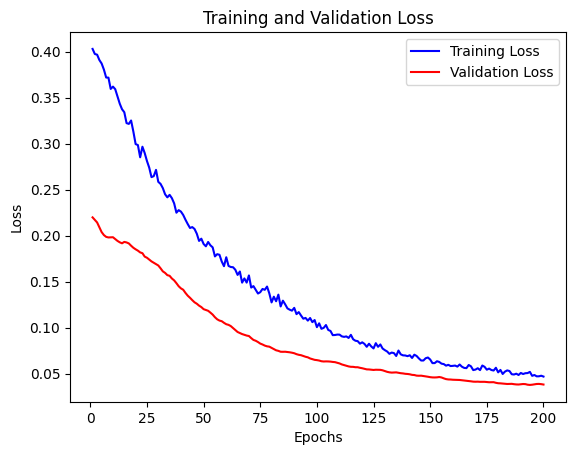

In [13]:
# Visualize losses *(MSE)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Difference in majority and minority class:
# We balance the dataset by generating no(synthetic data), in a way such that, after augmentation
# len(majority_class) would = len (minority_class)
difference = len(majority_class) - len(minority_class)
print(difference)

74


In [15]:
# Generating synthetic data as much as training data
# keeing data points same for report generation later
num_samples = len(X_train)
input_data = np.random.normal(size=(num_samples, 27)) # <-------

generated_data = autoencoder.predict(input_data) # <-------
generated_data.shape

2/2 [==============================] - 1s 20ms/step


(57, 1, 27)

In [16]:
# Re shape data
reshaped_data = generated_data.reshape(num_samples, -1)

# Convert it to a DataFrame
df_generated = pd.DataFrame(reshaped_data, columns=X_train.columns)

# Display the dataframe
df_generated.head(3)

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,temp,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt
0,0.048317,0.996909,0.390063,0.412119,-0.914344,0.11405,0.010989,-0.081614,2.942278,-0.124267,...,-0.279390,-0.594864,-0.074391,0.333075,-0.477875,0.508385,0.871591,0.408443,-0.479811,-1.788029
1,-2.588585,-1.288339,0.355105,-1.319441,-0.838243,-1.41306,0.210452,0.458912,-0.436917,-0.039663,...,-0.046166,0.037503,-0.397696,3.676929,-0.337113,0.365142,-2.856837,0.454262,1.285263,-2.119549
2,-3.427886,-2.124935,0.270053,-1.788841,-3.678783,-3.36057,0.100137,-1.781695,-1.860336,-0.127321,...,-1.175741,2.263288,22.357677,0.547108,4.491754,0.455988,10.795344,2.433148,3.142864,0.719935


In [17]:
print("Minority data shape:", X_train.shape)
print("Synthetic generated data shape:", df_generated.shape)

Minority data shape: (57, 27)
Synthetic generated data shape: (57, 27)


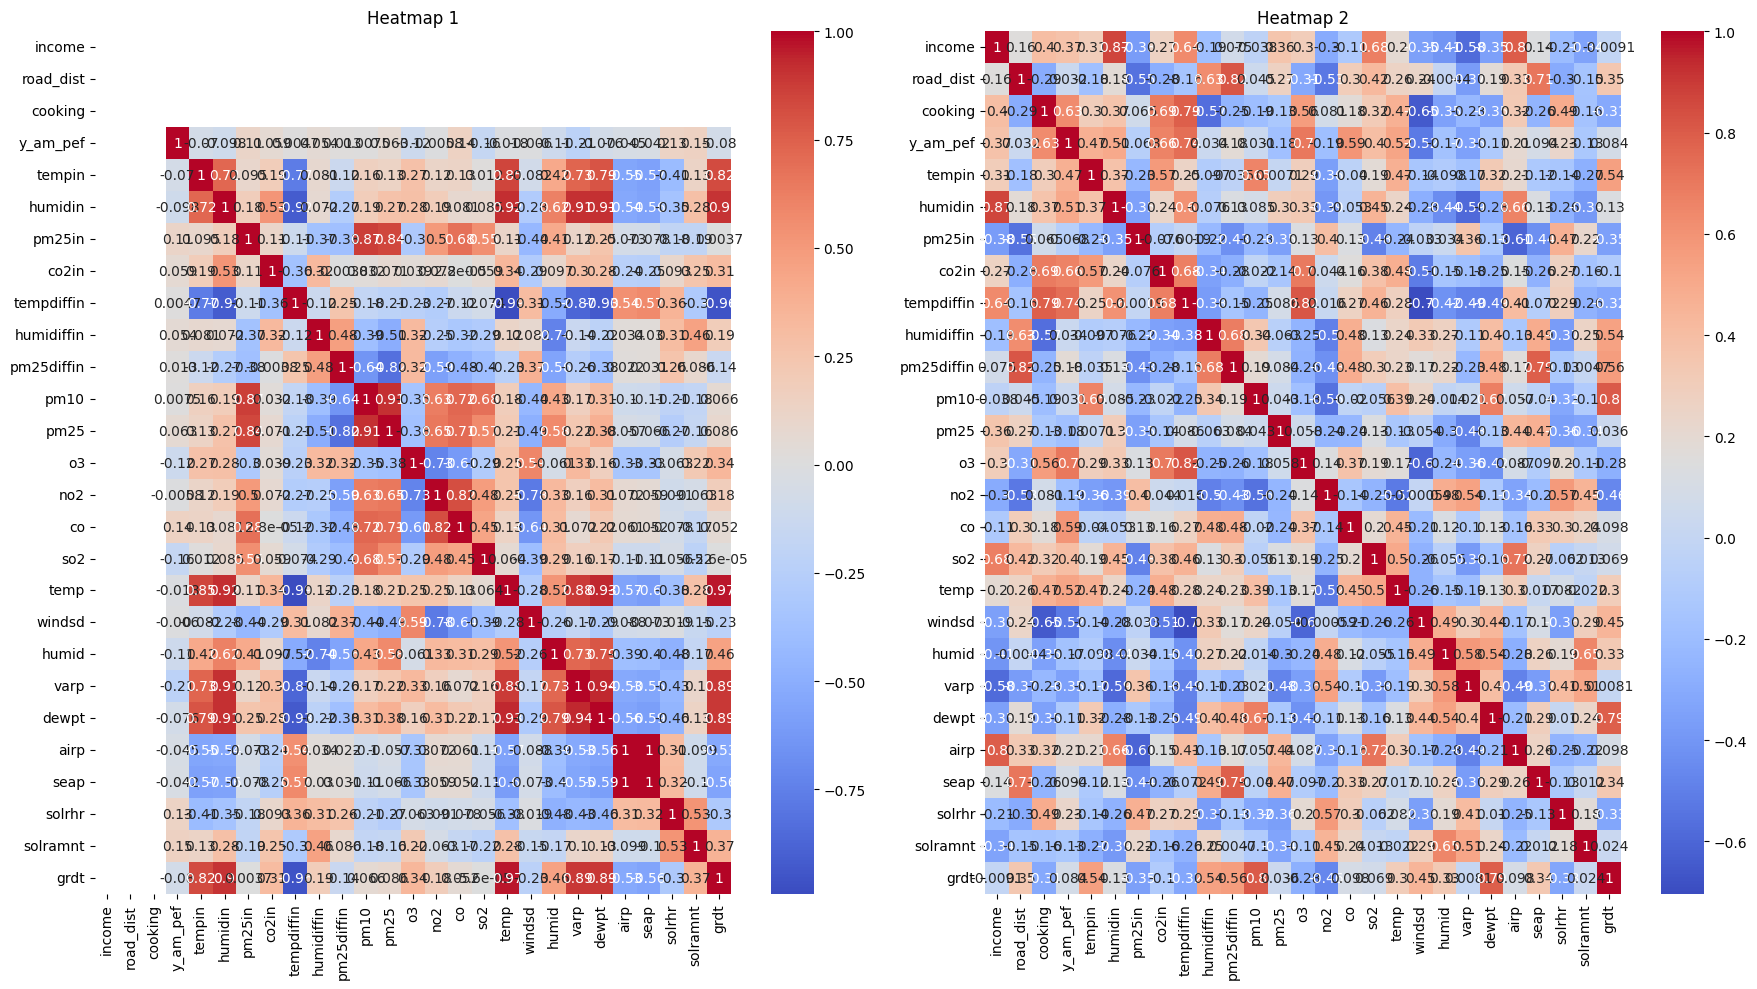

In [18]:
# Plot the Co-relation matrix
corr_matrix1 = X_train.corr()
corr_matrix2 = df_generated.corr()

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Heatmap 1')

sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Heatmap 2')

plt.tight_layout()

plt.show()

In [19]:
# Calculating mean and standard deviation of original and synthetic dataset
common_columns = set(X_train.columns) & set(df_generated.columns)
results = {}

for column in common_columns:

    mean_df1 = X_train[column].mean()
    std_df1 = X_train[column].std()
    mean_df2 = df_generated[column].mean()
    std_df2 = df_generated[column].std()


    results[column] = {'Mean_df1': mean_df1, 'Std_df1': std_df1,
                       'Mean_df2': mean_df2, 'Std_df2': std_df2}


comparison_df = pd.DataFrame(results)

# Display the comparison dataframe
print(comparison_df)

          tempdiffin      pm25  pm25diffin  solramnt      temp     tempin  \
Mean_df1    0.575035  0.262298    0.451018  0.292614  0.458368   0.517070   
Std_df1     0.204747  0.235978    0.123570  0.168519  0.219518   0.212387   
Mean_df2    5.540623  0.013414   -2.713723  0.493906  0.180213   6.432113   
Std_df2    11.076251  2.106311    6.433969  2.859004  1.352003  10.316807   

                co     co2in   humidin     dewpt  ...  y_am_pef    windsd  \
Mean_df1  0.309333  0.353421  0.356877  0.436825  ...  0.299105  0.364246   
Std_df1   0.204789  0.161209  0.184544  0.216589  ...  0.094818  0.258312   
Mean_df2  0.519872  3.036347  0.589137  2.825051  ...  2.531596 -0.310690   
Std_df2   4.864130  6.856042  6.135845  8.550934  ...  7.042670  2.716619   

              airp    solrhr   cooking      seap        o3    pm25in  \
Mean_df1  0.651579  0.547509  0.500000  0.649105  0.317561  0.308474   
Std_df1   0.177173  0.264203  0.000000  0.177951  0.155455  0.174530   
Mean_df2  0.

In [20]:
comparison_df.to_csv(FILE_NAME +'_mean&std.csv', index=True)

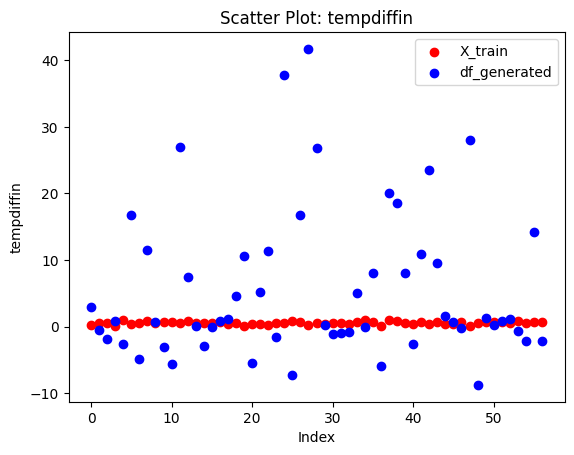

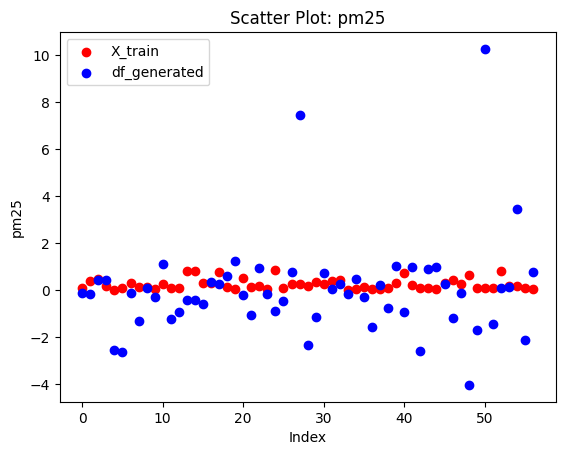

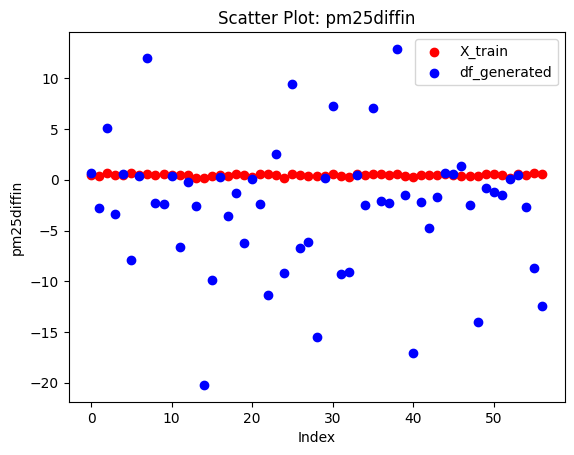

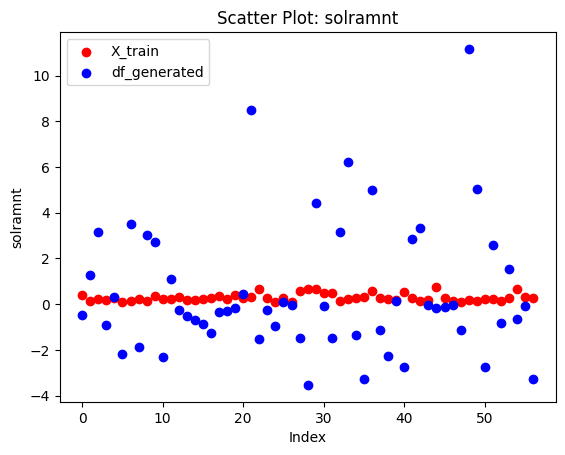

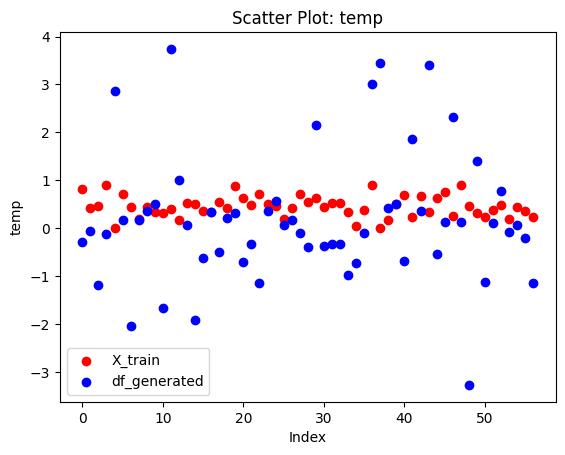

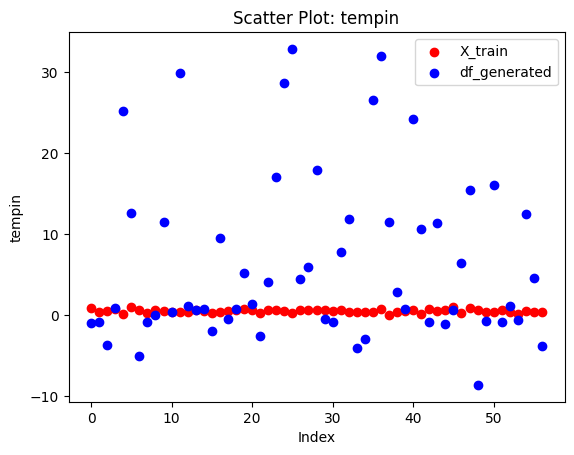

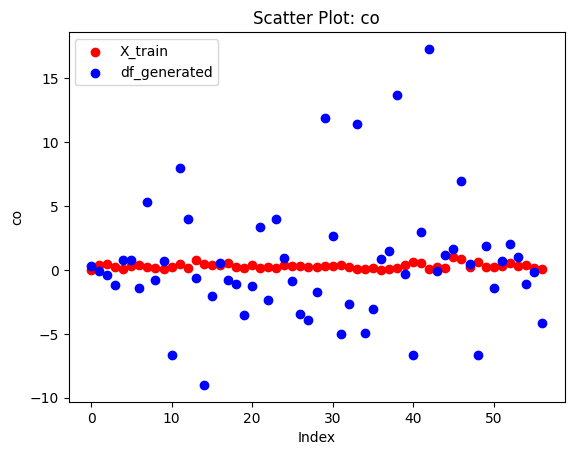

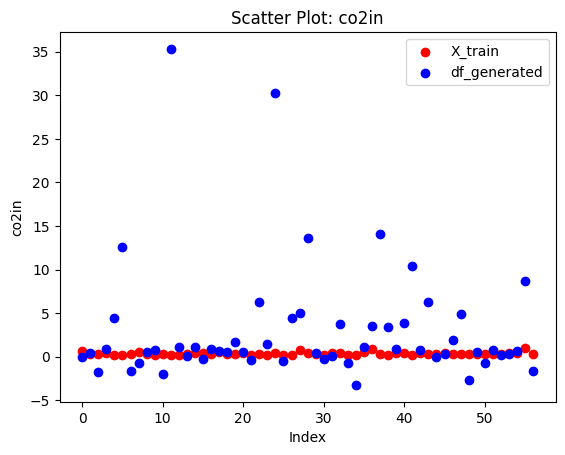

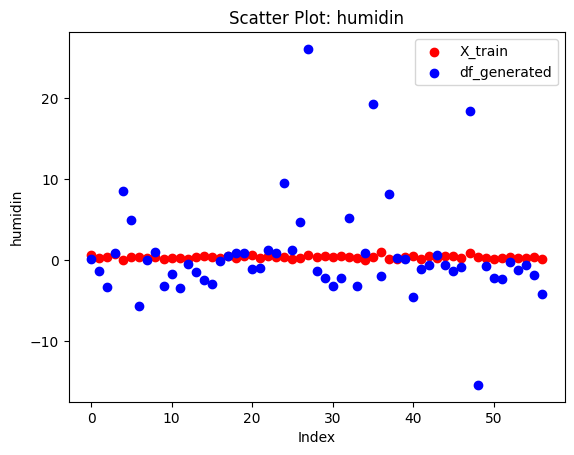

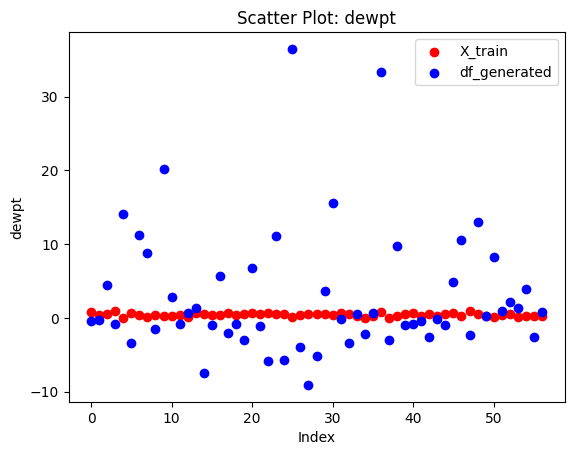

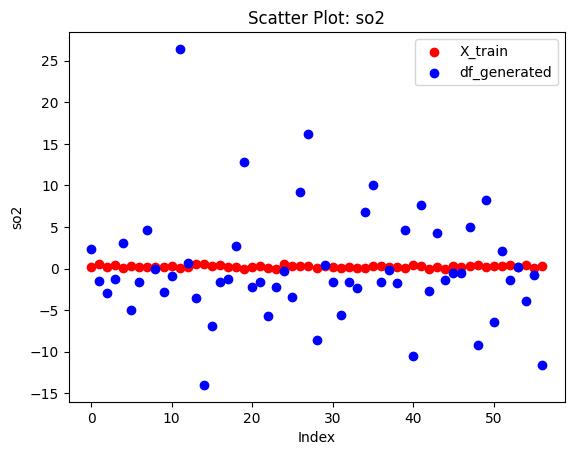

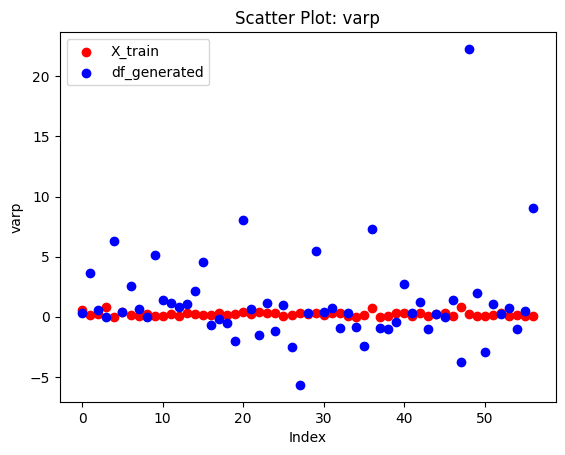

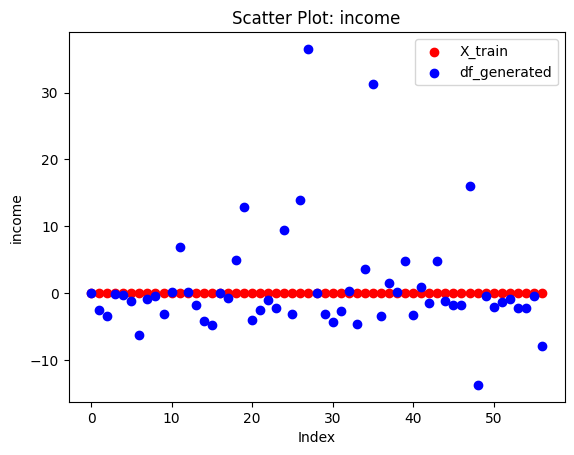

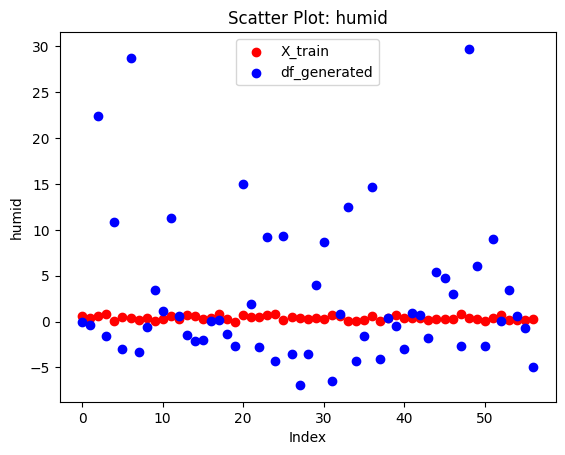

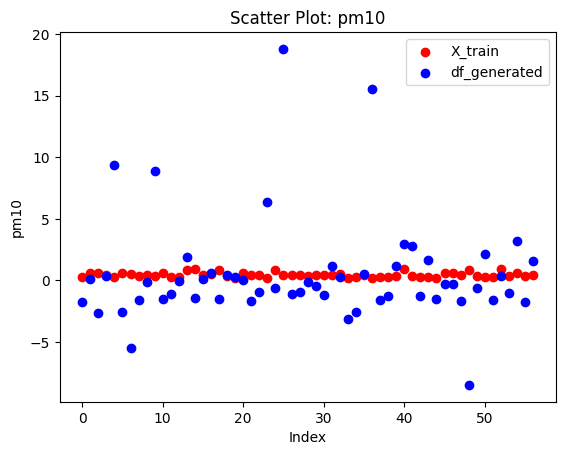

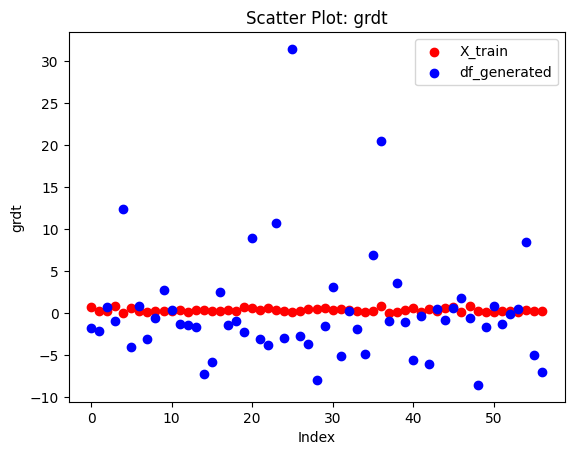

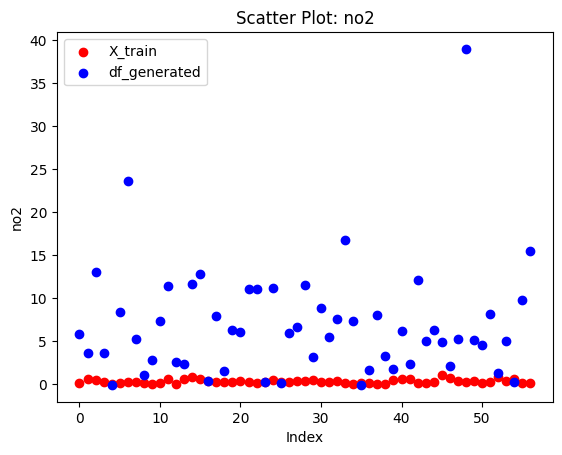

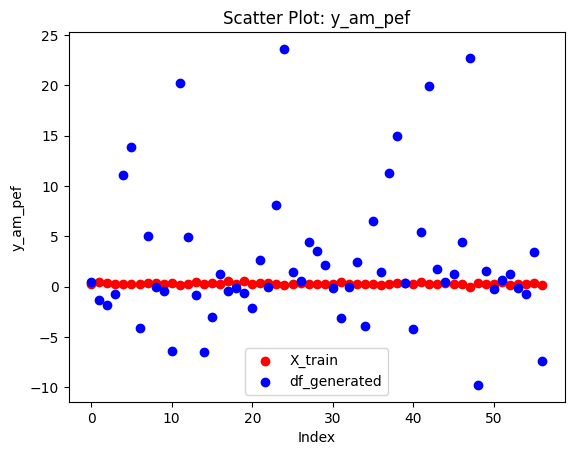

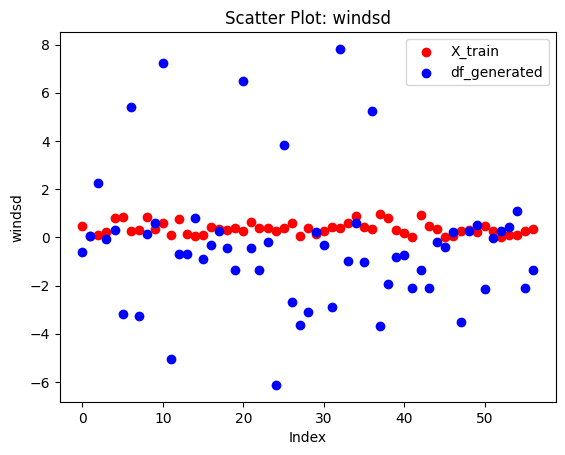

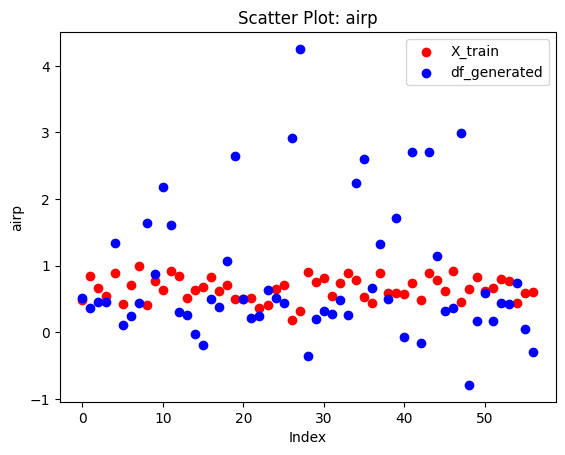

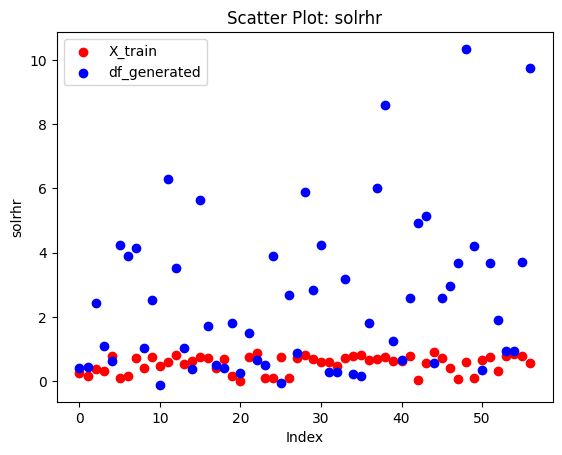

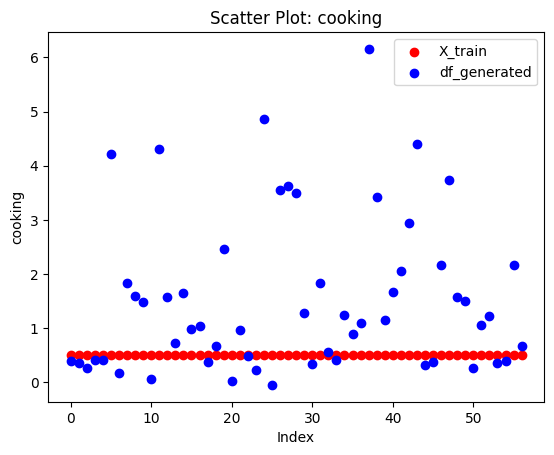

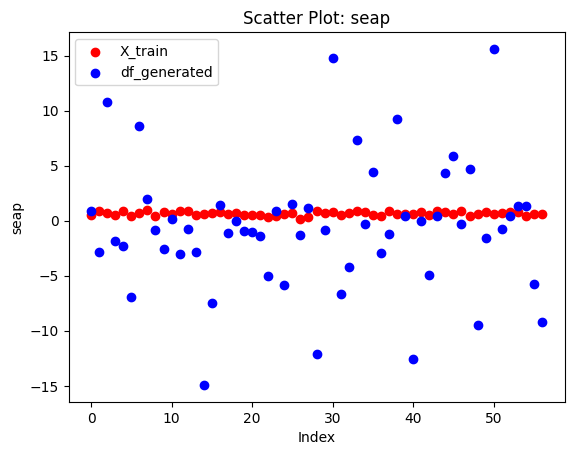

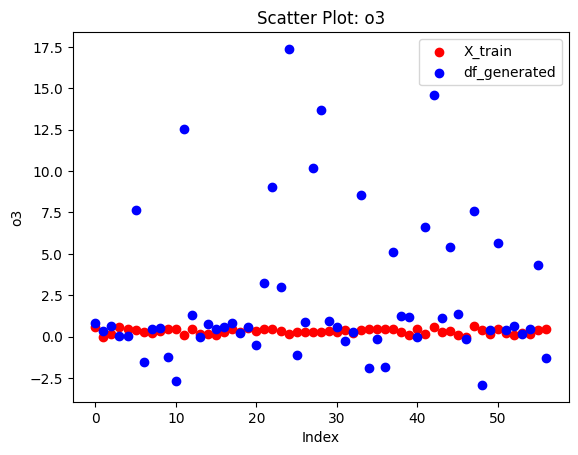

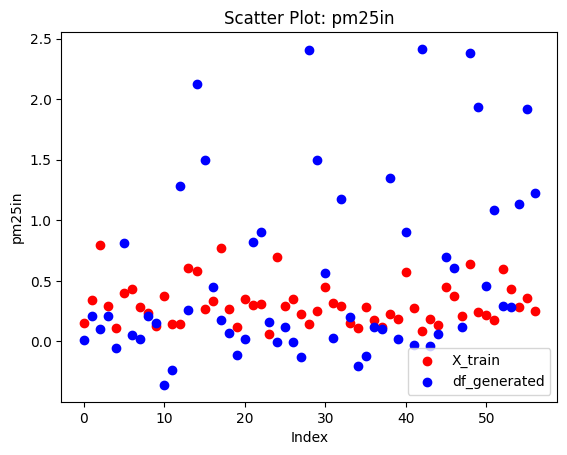

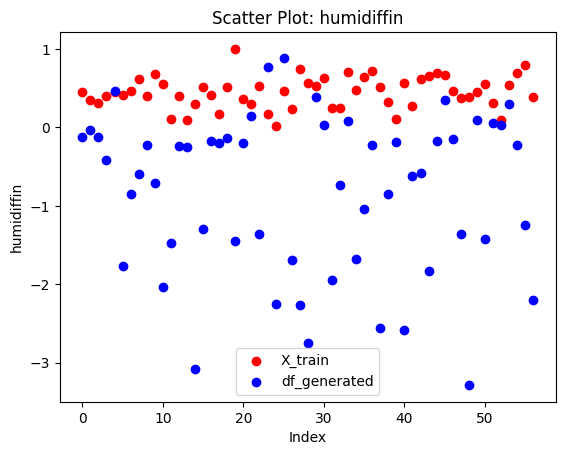

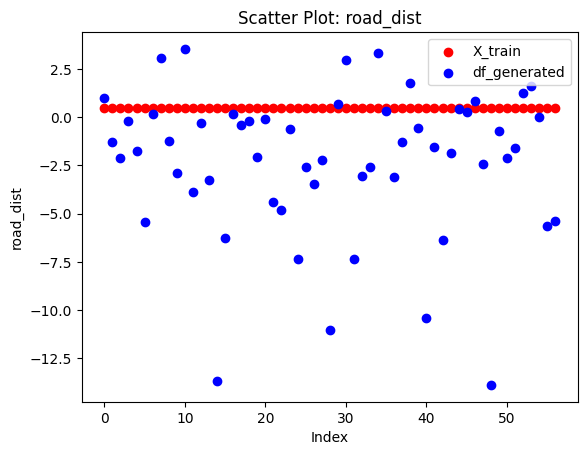

In [21]:
new_index = pd.RangeIndex(start=0, stop=57, step=1)
X_train = X_train.set_index(new_index)

import matplotlib.pyplot as plt

common_columns = set(X_train.columns) & set(df_generated.columns)
for column in common_columns:

    plt.scatter(X_train.index, X_train[column], color='red', label='X_train')
    plt.scatter(df_generated.index, df_generated[column], color='blue', label='df_generated')

    plt.title(f"Scatter Plot: {column}")
    plt.xlabel("Index")
    plt.ylabel(column)

    plt.legend()
    plt.show()

In [22]:
X_train.head()

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,temp,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt
0,0.0,0.5,0.5,0.268,0.851,0.660,0.154,0.628,0.247,0.455,...,0.822,0.484,0.643,0.581,0.804,0.486,0.475,0.246,0.399,0.694
1,0.0,0.5,0.5,0.415,0.425,0.253,0.342,0.344,0.585,0.346,...,0.430,0.038,0.394,0.164,0.427,0.842,0.836,0.156,0.120,0.272
2,0.0,0.5,0.5,0.310,0.556,0.429,0.796,0.357,0.576,0.310,...,0.466,0.107,0.580,0.218,0.512,0.662,0.658,0.394,0.223,0.291
3,0.0,0.5,0.5,0.284,0.813,0.749,0.291,0.384,0.154,0.396,...,0.898,0.226,0.774,0.772,0.906,0.536,0.518,0.311,0.202,0.836
4,0.0,0.5,0.5,0.228,0.143,0.000,0.108,0.146,0.992,0.445,...,0.007,0.806,0.086,0.000,0.000,0.896,0.906,0.787,0.286,0.021


In [23]:
df_generated.head()

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,temp,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt
0,0.048317,0.996909,0.390063,0.412119,-0.914344,0.114050,0.010989,-0.081614,2.942278,-0.124267,...,-0.279390,-0.594864,-0.074391,0.333075,-0.477875,0.508385,0.871591,0.408443,-0.479811,-1.788029
1,-2.588585,-1.288339,0.355105,-1.319441,-0.838243,-1.413060,0.210452,0.458912,-0.436917,-0.039663,...,-0.046166,0.037503,-0.397696,3.676929,-0.337113,0.365142,-2.856837,0.454262,1.285263,-2.119549
2,-3.427886,-2.124935,0.270053,-1.788841,-3.678783,-3.360570,0.100137,-1.781695,-1.860336,-0.127321,...,-1.175741,2.263288,22.357677,0.547108,4.491754,0.455988,10.795344,2.433148,3.142864,0.719935
3,-0.144994,-0.205019,0.416383,-0.744381,0.939316,0.863199,0.211398,0.827015,0.941043,-0.411381,...,-0.112314,-0.085866,-1.571178,0.005361,-0.842910,0.450999,-1.820175,1.095524,-0.923970,-0.934130
4,-0.214118,-1.779598,0.413619,11.073915,25.248648,8.472387,-0.052507,4.461546,-2.561910,0.463575,...,2.857363,0.321870,10.894672,6.263288,14.123974,1.339072,-2.285271,0.633596,0.302978,12.333216


In [24]:
# Replace the necessary columns
df_generated['income'] = X_train['income'].iloc[0]
df_generated['road_dist'] = X_train['road_dist'].iloc[0]
df_generated['cooking'] = X_train['cooking'].iloc[0]

In [25]:
# Adding back the class label
X_train['class'] = 0.0
df_generated['class'] = 0.0

In [26]:
X_train.to_csv(FILE_NAME +'_Original_minority_data.csv', index=False)
df_generated.to_csv(FILE_NAME + '_Synthetic_minority_data.csv', index=False)

In [27]:
# Synthetic Data Evaluation ## GRETEL.ai
# https://console.gretel.ai/login/
# https://console.gretel.ai/users/me/key

In [28]:
%%capture
!pip install -U gretel-client

In [29]:
import pandas as pd
from gretel_client.config import RunnerMode
from gretel_client.evaluation.quality_report import QualityReport
from gretel_client import configure_session
from gretel_client.projects import create_or_get_unique_project

# Specify your Gretel API Key

pd.set_option("max_colwidth", None)
configure_session(api_key="prompt", cache="yes", validate=True)

Gretel Api Key··········
Caching Gretel config to disk.
Using endpoint https://api.gretel.cloud
Logged in as sbhuvaji@seattleu.edu ✅


In [30]:
# Load and preview real-world data
real_data = FILE_NAME +'_Original_minority_data.csv'

real_df = pd.read_csv(real_data)
real_df

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt,class
0,0.0,0.5,0.5,0.268,0.851,0.660,0.154,0.628,0.247,0.455,...,0.484,0.643,0.581,0.804,0.486,0.475,0.246,0.399,0.694,0.0
1,0.0,0.5,0.5,0.415,0.425,0.253,0.342,0.344,0.585,0.346,...,0.038,0.394,0.164,0.427,0.842,0.836,0.156,0.120,0.272,0.0
2,0.0,0.5,0.5,0.310,0.556,0.429,0.796,0.357,0.576,0.310,...,0.107,0.580,0.218,0.512,0.662,0.658,0.394,0.223,0.291,0.0
3,0.0,0.5,0.5,0.284,0.813,0.749,0.291,0.384,0.154,0.396,...,0.226,0.774,0.772,0.906,0.536,0.518,0.311,0.202,0.836,0.0
4,0.0,0.5,0.5,0.228,0.143,0.000,0.108,0.146,0.992,0.445,...,0.806,0.086,0.000,0.000,0.896,0.906,0.787,0.286,0.021,0.0
5,0.0,0.5,0.5,0.237,1.000,0.393,0.399,0.183,0.403,0.418,...,0.852,0.448,0.400,0.659,0.428,0.420,0.106,0.073,0.534,0.0
6,0.0,0.5,0.5,0.273,0.598,0.380,0.437,0.293,0.606,0.468,...,0.260,0.391,0.170,0.437,0.709,0.705,0.173,0.130,0.284,0.0
7,0.0,0.5,0.5,0.375,0.257,0.234,0.287,0.509,0.807,0.615,...,0.285,0.129,0.035,0.156,1.000,1.000,0.738,0.230,0.116,0.0
8,0.0,0.5,0.5,0.348,0.644,0.342,0.239,0.323,0.610,0.394,...,0.834,0.427,0.203,0.453,0.407,0.409,0.417,0.127,0.291,0.0
9,0.0,0.5,0.5,0.257,0.474,0.170,0.130,0.218,0.691,0.683,...,0.330,0.012,0.052,0.204,0.766,0.764,0.746,0.342,0.258,0.0


In [31]:
# Load and preview synthetic data
synth_data = FILE_NAME + '_Synthetic_minority_data.csv'

synth_df = pd.read_csv(synth_data)
synth_df

,income,road_dist,cooking,y_am_pef,tempin,humidin,pm25in,co2in,tempdiffin,humidiffin,...,windsd,humid,varp,dewpt,airp,seap,solrhr,solramnt,grdt,class
0,0.0,0.5,0.5,0.412119,-0.914344,0.114050,0.010989,-0.081614,2.942278,-0.124267,...,-0.594864,-0.074391,0.333075,-0.477875,0.508385,0.871591,0.408443,-0.479811,-1.788029,0.0
1,0.0,0.5,0.5,-1.319441,-0.838243,-1.413060,0.210452,0.458912,-0.436917,-0.039663,...,0.037503,-0.397696,3.676929,-0.337113,0.365142,-2.856837,0.454262,1.285263,-2.119549,0.0
2,0.0,0.5,0.5,-1.788841,-3.678783,-3.360570,0.100137,-1.781696,-1.860336,-0.127321,...,2.263288,22.357677,0.547107,4.491754,0.455989,10.795344,2.433148,3.142864,0.719935,0.0
3,0.0,0.5,0.5,-0.744381,0.939316,0.863199,0.211398,0.827015,0.941043,-0.411381,...,-0.085866,-1.571178,0.005361,-0.842910,0.450999,-1.820175,1.095524,-0.923970,-0.934130,0.0
4,0.0,0.5,0.5,11.073916,25.248648,8.472387,-0.052507,4.461546,-2.561910,0.463575,...,0.321870,10.894672,6.263288,14.123974,1.339072,-2.285271,0.633596,0.302978,12.333216,0.0
5,0.0,0.5,0.5,13.905133,12.567463,4.998921,0.811947,12.542932,16.821882,-1.762092,...,-3.170122,-3.022578,0.411990,-3.382205,0.100918,-6.900554,4.248056,-2.201853,-4.081636,0.0
6,0.0,0.5,0.5,-4.147464,-5.023432,-5.650756,0.050368,-1.582929,-4.855866,-0.854085,...,5.425275,28.697544,2.589163,11.237266,0.240686,8.583023,3.891877,3.499549,0.798523,0.0
7,0.0,0.5,0.5,5.044649,-0.850914,-0.024382,0.021824,-0.697287,11.480394,-0.600222,...,-3.245095,-3.310808,0.675678,8.756552,0.445486,1.981095,4.141647,-1.865598,-3.087000,0.0
8,0.0,0.5,0.5,-0.083576,-0.022183,0.993814,0.208593,0.570937,0.666747,-0.227331,...,0.134625,-0.594531,-0.049199,-1.532333,1.645396,-0.852580,1.022157,3.014631,-0.639982,0.0
9,0.0,0.5,0.5,-0.431357,11.509184,-3.234313,0.148787,0.728015,-3.106345,-0.713560,...,0.612476,3.386249,5.173793,20.242176,0.867263,-2.614307,2.526356,2.728121,2.702647,0.0


In [32]:
# Create a Quality Report
report = QualityReport(data_source=synth_data, ref_data=real_data)
report.run()

In [33]:
# Synthetic Data Quality Score (SQS)
report.peek()

{'raw_score': 42.55555555555555, 'grade': 'Moderate', 'score': 42}

In [34]:
# Quality Report as HTML
import IPython

IPython.display.HTML(report.as_html, metadata=dict(isolated=True))

How to interpret your SQS,Excellent,Good,Moderate,Poor,Very Poor
Suitable for machine learning or statistical analysis,,,,,
Suitable for balancing or augmenting machine learning data sources,,,,,
Suitable for pre-production testing environments,,,,,
Suitable for demo environments or mock data,,,,,
Improve your model using our tips and advice,,,,,
Significant tuning required to improve model,,,,,
Data Sharing Use Case,Excellent,Very Good,Good,Normal,Poor
"Internally, within the same team",,,,,
"Internally, across different teams",,,,,
"Externally, with trusted partners",,,,,


In [35]:
# View as dictionary
report.as_dict

{'left_rows': 57,
 'left_cols': 28,
 'right_rows': 57,
 'right_cols': 28,
 'fields': [{'name': 'varp',
   'left_field_features': {'name': 'varp',
    'type': 'numeric',
    'count': 57,
    'unique_count': 53,
    'unique_percent': 92.9825,
    'missing_count': 0,
    'missing_percent': 0.0,
    'min_str_length': 3,
    'max_str_length': 5,
    'avg_str_length': 4.8246,
    'min_value': 1,
    'max_value': 0.1,
    'min_precision': 0,
    'max_precision': 3},
   'right_field_features': {'name': 'varp',
    'type': 'numeric',
    'count': 57,
    'unique_count': 57,
    'unique_percent': 100.0,
    'missing_count': 0,
    'missing_percent': 0.0,
    'min_str_length': 8,
    'max_str_length': 12,
    'avg_str_length': 9.4737,
    'min_value': -10.0,
    'max_value': 10.0,
    'min_precision': 5,
    'max_precision': 10},
   'left_distribution': {'(-1.372, 0.778]': 0.9824561403508771,
    '(0.778, 2.929]': 0.017543859649122806},
   'right_distribution': {'(-1.372, 0.778]': 0.4912280701754